# Butterfly Classification with CNN

Dataset:
- Source - https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification
- Classes - 75
- Images - 6499 labeled, 2786 not labeled

CNN:
- ResNet-50 - Pretrained with ImageNet
- ResNet-50 - Pretrained with autoencoder

Classifier:
- Dense layers

In [1]:
import numpy as np
from PIL import Image

import datetime

import tensorflow as tf

from sklearn.preprocessing import LabelEncoder

In [2]:
# Settings
train_csv = './butterfly/Training_set.csv'
train_images = './butterfly/train/'
model_folder = './butterfly/models/'
logs_folder = './butterfly/logs/'

# Dataset settings
train_vol = 0.8

# Train settings
batch_size = 16
epochs = 20

In [3]:
# !unzip /content/drive/MyDrive/Butterfly_class/Training_set.zip

## Load Data

In [4]:
import pandas as pd

data = pd.read_csv(train_csv)
data_x = data['filename']
data_y = data['label']

In [5]:
labels = np.unique(data_y.values)
categories = labels.shape[0]

print(categories)

75


In [6]:
#  # Load train data
#  train_dataset = tf.data.experimental.make_csv_dataset(
#     train_csv,
#     batch_size,
#     label_name='label',
#     header=True
#  )

In [7]:
# tf.data.experimental.cardinality(train_dataset).numpy()

In [8]:
# # Get unique labels
# all_labels = np.fromiter(train_dataset.map(lambda x, y: y), str)
# labels = np.unique(all_labels)
# categories = labels.shape[0]

In [6]:
# Fit one hot encoder
label_encoder = LabelEncoder()
label_encoder.fit(labels)

# Encode labels
data_y_vals = label_encoder.transform(data_y.values)
data_y_vals = tf.keras.utils.to_categorical(data_y_vals)

# def encode_label(y):
#   return tf.keras.utils.to_categorical(
#       tf.py_function(lambda x: label_encoder.transform(x), [y], [tf.uint8]), categories
#   )

In [7]:
# Load images
data_x = [tf.constant(np.array(Image.open(train_images + img_name))) for img_name in data_x.values]

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((data_x, data_y_vals))

In [9]:
from os import error
# Load images and preprocess them
def preprocess_data(img, label):

  # def get_path(_img_name):
  #   return train_images + _img_name.numpy()

  # Load image
  # img = tf.keras.utils.load_img(
  #     tf.py_function(get_path, [img_name], [tf.string])
  # )

  # def exception_factory(exception, message):
  #   return exception(message)

  # def load_file(filename):
  #   # raise exception_factory(ValueError, filename.numpy())
  #   return tf.constant(np.array(Image.open(filename.numpy())))

  # img = tf.py_function(load_file, [img_name], [tf.uint8])

  # Normalize image
  img = tf.cast(img, tf.float32) / 255.0

  return img, label

# def preprocess_data(img, label):
#   return tf.cast(img, tf.float32) / 255.0

train_dataset = train_dataset.map(preprocess_data)

In [10]:
for image, label in train_dataset.take(1):
  input_tensor = tf.keras.Input(shape=image.shape)

In [11]:
input_tensor

<tf.Tensor 'input_1:0' shape=(None, 224, 224, 3) dtype=float32>

## Visualise data

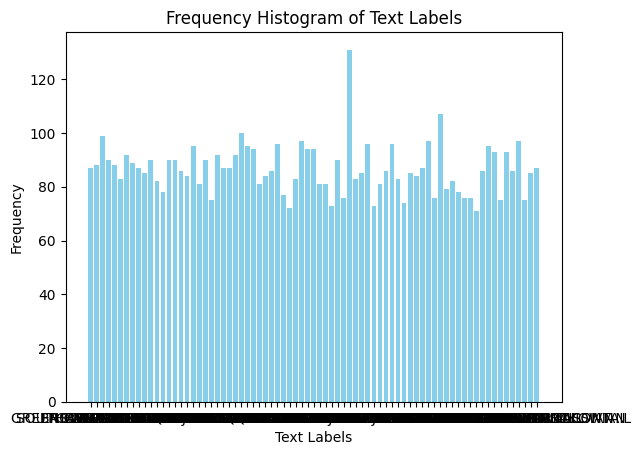

In [12]:
import matplotlib.pyplot as plt
from collections import Counter

# Visualise label distribution

label_counts = Counter(data_y)
labels, frequencies = zip(*label_counts.items())

# Plot the histogram
plt.figure(figsize=(18, 6))
plt.bar(labels, frequencies, color='skyblue')
plt.xlabel('Text Labels')
plt.ylabel('Frequency')
plt.title('Frequency Histogram of Text Labels')
plt.show()

In [16]:
# Keep in mind, might need to remove extra labels to make repartition of data uniform if need be

## Prepare data

### AE Dataset

In [ ]:
# Switch to autoencoder dataset
def switch_ae(images, labels):
  return images, images

train_dataset = train_dataset.map(switch_ae)

### Split train test

In [13]:
# Split into train/validate
train_size = int(train_vol * len(train_dataset))

test_dataset = train_dataset.skip(train_size)
train_dataset = train_dataset.take(train_size)

In [14]:
# Batch data
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

## Autoencoder ResNet-50

### Define Model

In [14]:
class resnet_deconv_block(tf.keras.layers.Layer): # Using resize rather than deconv

  def __init__(self, filter, res_filter = False, scale = 1, kernel_size = 3):
    super().__init__()

    self.conv1 = tf.keras.layers.Conv2D(filter, kernel_size,
                                        padding='same', use_bias=False)
    self.bn1 = tf.keras.layers.BatchNormalization(axis=3)

    self.conv2 = tf.keras.layers.Conv2D(filter, kernel_size,
                                        padding='same', use_bias=False)
    self.bn2 = tf.keras.layers.BatchNormalization(axis=3)

    self.act = tf.keras.layers.Activation('relu')

    self.resize = scale > 1
    self.scale = scale

    self.res_filter = res_filter
    if self.res_filter:
      self.conv_res = tf.keras.layers.Conv2D(filter, 1,
                                        padding='same', use_bias=False)
      
      # config
      self.config_args = {
          'filter': filter,
          'res_filter': res_filter,
          'scale': scale,
          'kernel_size': kernel_size
      }

  def build(self, input_shape):
    if self.resize:
      self.resize = tf.keras.layers.experimental.preprocessing.Resizing(
          input_shape[1] * self.scale, input_shape[2] * self.scale
      )

  def call(self, x, training=False):

    if self.resize:
      x = self.resize( x )

    conv1 = self.act( self.bn1( self.conv1( x ) ) )
    conv2 = self.conv2( conv1 )

    if self.res_filter:
      x = self.conv_res( x )

    return self.act( self.bn2( x + conv2 ) )
  
  def get_config(self):

        config = super().get_config().copy()
        config.update(self.config_args)
        return config


In [15]:
resnet_50_model_ae = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor
)

resnet_50_model_ae.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
resnet_50_decoder = tf.keras.Sequential([

  tf.keras.layers.Input(shape=(7, 7, 2048)),

  resnet_deconv_block(1024, scale=2, res_filter=True),
  resnet_deconv_block(512, scale=2, res_filter=True),
  resnet_deconv_block(256, scale=2, res_filter=True),
  resnet_deconv_block(64, scale=2, res_filter=True),
  resnet_deconv_block(32, scale=2, res_filter=True),

  tf.keras.layers.Conv2D(3, 3, padding='same')

])

resnet_50_decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_deconv_block (resnet_ (None, 14, 14, 1024)      30416896  
_________________________________________________________________
resnet_deconv_block_1 (resne (None, 28, 28, 512)       7606272   
_________________________________________________________________
resnet_deconv_block_2 (resne (None, 56, 56, 256)       1902592   
_________________________________________________________________
resnet_deconv_block_3 (resne (None, 112, 112, 64)      201216    
_________________________________________________________________
resnet_deconv_block_4 (resne (None, 224, 224, 32)      29952     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 224, 224, 3)       867       
Total params: 40,157,795
Trainable params: 40,150,243
Non-trainable params: 7,552
________________________________________

In [17]:
auto_encoder = tf.keras.Sequential([
    resnet_50_model_ae,
    resnet_50_decoder
])

### Train

In [24]:
# Compile settings
optimizer = 'adam'
loss = tf.keras.losses.MeanSquaredError()

In [25]:
# Compile model
auto_encoder.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [26]:
model_name = f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}-resnet_50_autoencode.h5'

model_loc = f'{model_folder}{model_name}'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_loc, monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)

logs_loc = f'{logs_folder}{model_name}'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_loc, histogram_freq=1)

# Train model
run_hist = auto_encoder.fit(train_dataset, validation_data=test_dataset,
                      epochs=epochs, batch_size=batch_size,
                      callbacks=[checkpoint, tensorboard_callback])

Epoch 1/20
  1/325 [..............................] - ETA: 0s - loss: 1.4130 - accuracy: 0.2254WARNING:tensorflow:From c:\Users\benoi\AppData\Local\pypoetry\Cache\virtualenvs\tp-8inf804-DR3c3r2e-py3.8\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
325/325 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 0.6150
Epoch 00001: val_accuracy improved from -inf to 0.54121, saving model to ./butterfly/models\20231211-122256-resnet_50_autoencode.h5
325/325 [==============================] - 276s 849ms/step - loss: 0.0482 - accuracy: 0.6150 - val_loss: 0.0948 - val_accuracy: 0.5412
Epoch 2/20
325/325 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.7020
Epoch 00002: val_accuracy improved from 0.54121 to 0.55738, saving model to ./butterfly/models\20231211-122256-resnet_

### Visualise Training

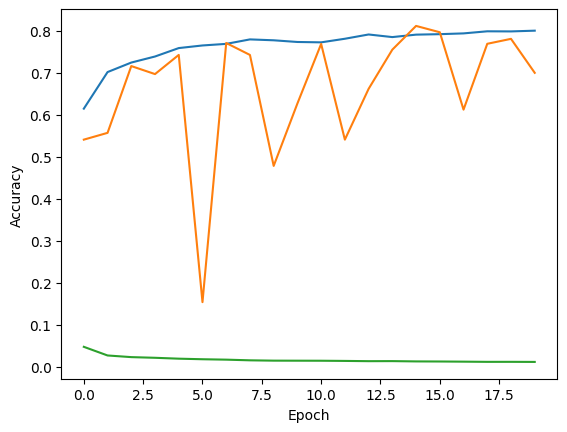

In [27]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.plot(run_hist.history['accuracy'], label='train')
plt.plot(run_hist.history['val_accuracy'], label='test')
plt.plot(run_hist.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [29]:
# Load top autoencoder model
ae_weight_path = model_loc
auto_encoder.load_weights(ae_weight_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


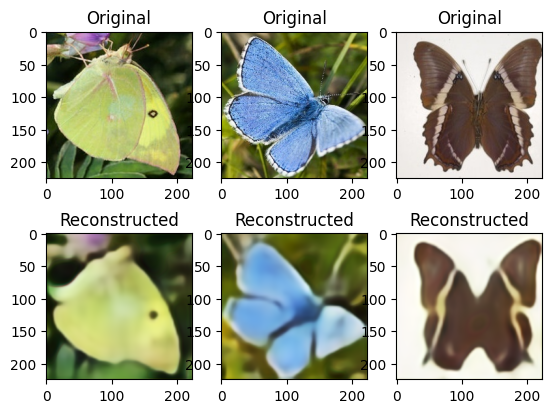

In [32]:
original_images = train_dataset.take(1) # test_dataset.take(1)
reconstructed_images = auto_encoder.predict(original_images)

original_images = list(original_images.as_numpy_iterator())
reconstructed_images = reconstructed_images

for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(original_images[0][0][i])
    plt.title('Original')

    plt.subplot(2, 3, i + 4)
    plt.imshow(reconstructed_images[i])
    plt.title('Reconstructed')

plt.show()

## Classifier

### Transfer Learning

#### ResNet-50 Autoencoder

In [18]:
# Load autoencoder model
ae_weight_path = f"{model_folder}20231211-122256-resnet_50_autoencode.h5"
auto_encoder.load_weights(ae_weight_path)

model_head = auto_encoder.layers[0]

#### ResNet-50 ImageNet

In [16]:
model_head = resnet_50_model_ae

#### Freeze model

In [17]:
for layer in model_head.layers[:143]:
  layer.trainable = False

### ResNet-50

In [19]:
model_head = tf.keras.applications.ResNet50(
    include_top=False,
    input_tensor=input_tensor
)

### Add Classification

In [18]:
classifier = tf.keras.Sequential([
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1024, kernel_regularizer='l2'),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(categories),
    tf.keras.layers.Activation('softmax')
])

data_gen = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1, seed=53),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1, seed=53),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, seed=53),
        tf.keras.layers.experimental.preprocessing.RandomFlip(seed=53),
    ]
)

classifier_model = tf.keras.Sequential([
    data_gen,
    model_head,
    classifier
])

### Train

In [19]:
epochs = 100

In [20]:
# Compile settings
optimizer = 'adam'
loss = tf.keras.losses.CategoricalCrossentropy(
    label_smoothing=0.2
)

In [21]:
# Compile model
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [22]:
model_name = f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}-resnet_50_classifier.h5'

model_loc = f'{model_folder}{model_name}'
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_loc, monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)

logs_loc = f'{logs_folder}{model_name}'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_loc, histogram_freq=1)

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train model
run_hist = classifier_model.fit(train_dataset, validation_data=test_dataset,
                      epochs=epochs, batch_size=batch_size,
                      callbacks=[checkpoint, tensorboard_callback])

Epoch 1/100
  1/325 [..............................] - ETA: 0s - loss: 25.5049 - accuracy: 0.0000e+00WARNING:tensorflow:From c:\Users\benoi\AppData\Local\pypoetry\Cache\virtualenvs\tp-8inf804-DR3c3r2e-py3.8\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
325/325 [==============================] - ETA: 0s - loss: 8.9756 - accuracy: 0.0233
Epoch 00001: val_accuracy improved from -inf to 0.02923, saving model to ./butterfly/models\20231212-150856-resnet_50_classifier.h5
325/325 [==============================] - 60s 183ms/step - loss: 8.9756 - accuracy: 0.0233 - val_loss: 4.6508 - val_accuracy: 0.0292
Epoch 2/100
325/325 [==============================] - ETA: 0s - loss: 4.2856 - accuracy: 0.0394
Epoch 00002: val_accuracy improved from 0.02923 to 0.03462, saving model to ./butterfly/models\20231212-150856-r

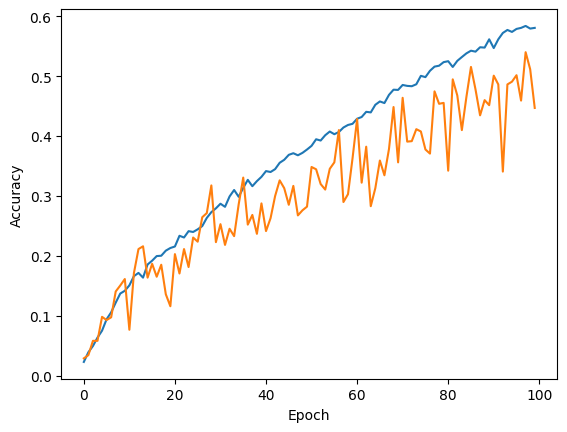

In [23]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.plot(run_hist.history['accuracy'], label='train')
plt.plot(run_hist.history['val_accuracy'], label='test')
# plt.plot(run_hist.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()